## Exercise

**1. Load data**

In [10]:
## read data
congress <- readRDS("../data/uss.rds")
uss <- readRDS("../data/uss-tweets.rds")

## load tidyverse
suppressPackageStartupMessages(library(tidyverse))

## merge data, drop duplicates
uss <- left_join(uss, congress)
uss <- unique(as_tibble(uss))

Joining, by = "user_id"


In [11]:
## remove URLs
uss$text <- stringr::str_replace_all(uss$text, "https?[[:graph:]]+", "")

## remove screen names
uss$text <- stringr::str_replace_all(uss$text, "@\\S+", "")

## remove hashtags
uss$text <- stringr::str_replace_all(uss$text, "#\\S+", "")

**3. Conduct sentiment analysis on the tweets by examining the use of POSITIVE words (as described in the "bing" dictionary). Plot the top 20 disproportionately used words by each party (among words used at least twice).**

In [12]:
## load tidytext
library(tidytext)

## tokenize by word
usst <- unnest_tokens(uss[, c("user_id", "text", "ideology")], word, text)

## positive words from bing
bing_pos <- get_sentiments("bing") %>%
filter(sentiment=="positive")

## join with tokenized data and then count
sa <- usst %>%
  mutate(party = ifelse(ideology > .5, "R", "D")) %>%
  inner_join(bing_pos) %>%
  group_by(party) %>%
  count(word, sort = TRUE)

Joining, by = "word"


In [13]:
## if necessary: remove any domain specific words that shouldn't probably count the way
## identify and pull all words that appear at least twice in both groups
sas <- sa %>%
    filter(!word %in% c("trump", "conservative", "liberal")& n > 1) %>%
    group_by(word) %>%
    mutate(tot = n()) %>%
    ungroup() %>%
    filter(tot == 2) %>%
    select(-tot)
## pull the n most used positive words from each group
n <- 20
sas10 <- sas %>%
    spread(party, n) %>%
    mutate(d = D / (D + R)) %>%
    arrange(-d) %>%
    .[c(1:n, (nrow(.) - (n - 1)):nrow(.)), ] %>%
    select(-D, -R) %>%
    mutate(r = 1 - d) %>%
    gather(party, prop, -word) %>%
    ## set factor levels (for plotting purposes)
    mutate(word = factor(word, levels = unique(word)))

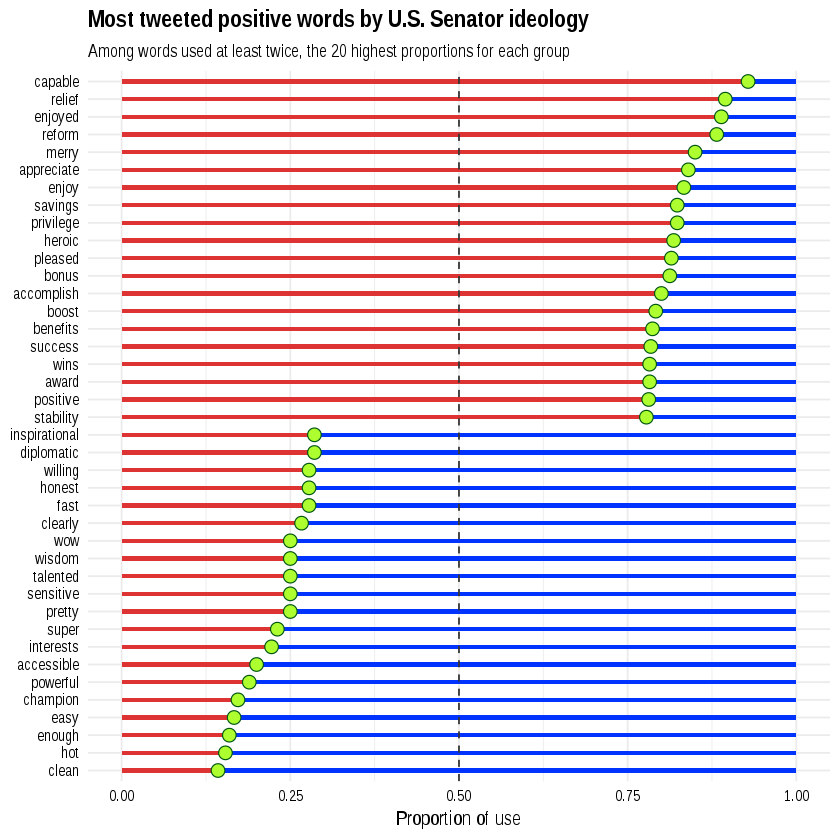

In [14]:
## plot the [filled] proportions using geom_col and stylize with geom_point
sas10 %>%
    ggplot(aes(word, prop, fill = party)) +
    geom_col(width = .25, show.legend = FALSE) +
    labs(y = "Proportion of use", x = NULL,
        title = "Most tweeted positive words by U.S. Senator ideology",
        subtitle = "Among words used at least twice, the 20 highest proportions for each group") +
    coord_flip() + 
    scale_fill_manual(values = c(r = "#dd3333", d = "#0033ff")) + 
    theme_minimal(base_size = 12, base_family = "Arial Narrow") + 
    theme(strip.placement = "outside", 
        plot.title = element_text(face = "bold"),
        axis.text = element_text(colour = "black")) + 
    geom_hline(yintercept = .50, linetype = 2, 
        colour = "gray20") +
    geom_point(data = filter(sas10, party == "r"), aes(y = prop), fill = "greenyellow",
        size = 3.5, shape = 21, colour = "#005511")

**4. Perform topic modeling on the text of the tweets. The type of topic modeling, how it's conducted (or what packages), etc. are entirely up to you (you can look up topic modeling method(s) in the Tidy Text Mining book, or you can find some other resource we haven't even talked about). Be as creative or adventerous as you want!**

**The output can be anything (print out of summary table/info, a plot/visual, or a write-up), but it should convey your interpretation [at least some] of the extracted topics.**.

In [18]:
## topic modeling code goes here!
str(sas)

Classes 'tbl_df', 'tbl' and 'data.frame':	534 obs. of  3 variables:
 $ party: chr  "R" "R" "D" "R" ...
 $ word : chr  "great" "work" "work" "support" ...
 $ n    : int  367 281 248 244 213 213 200 196 187 165 ...


In [19]:
str(sas10)

Classes 'tbl_df', 'tbl' and 'data.frame':	80 obs. of  3 variables:
 $ word : Factor w/ 40 levels "clean","hot",..: 1 2 3 4 5 6 7 8 9 10 ...
 $ party: chr  "d" "d" "d" "d" ...
 $ prop : num  0.857 0.846 0.84 0.833 0.828 ...


In [23]:
head(sas,5)

party,word,n
R,great,367
R,work,281
D,work,248
R,support,244
D,protect,213


In [17]:
# Load
library("wordcloud")
library("RColorBrewer")

Loading required package: RColorBrewer


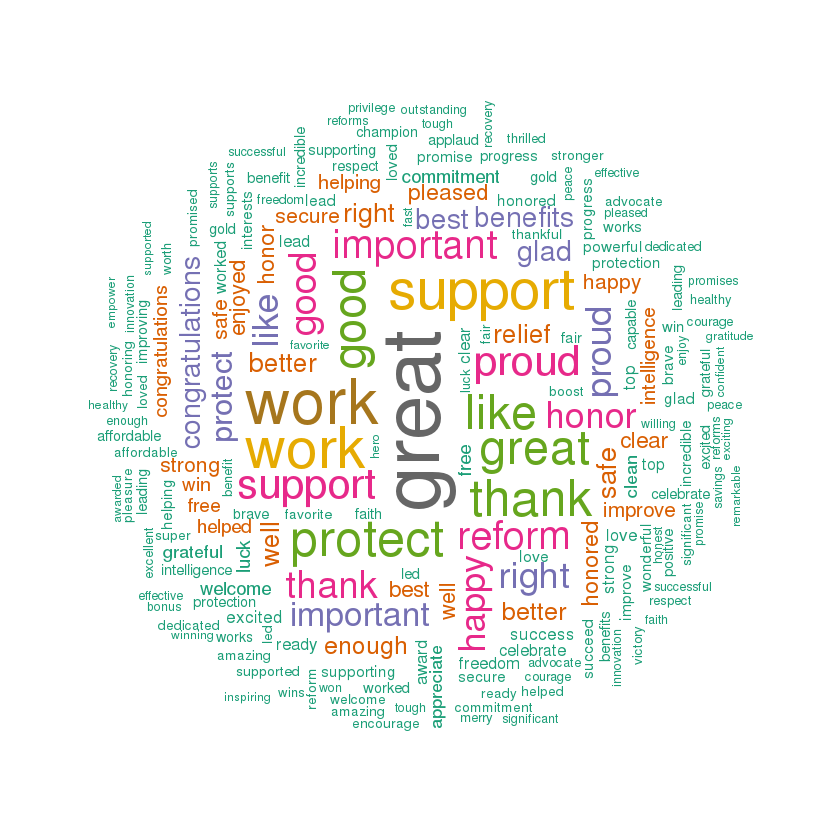

In [20]:
#practice wordcloud
set.seed(1234)
wordcloud(words = sas$word, freq = sas$n, min.freq = 1,
          max.words=200, random.order=FALSE, rot.per=0.35, 
          colors=brewer.pal(8, "Dark2"))

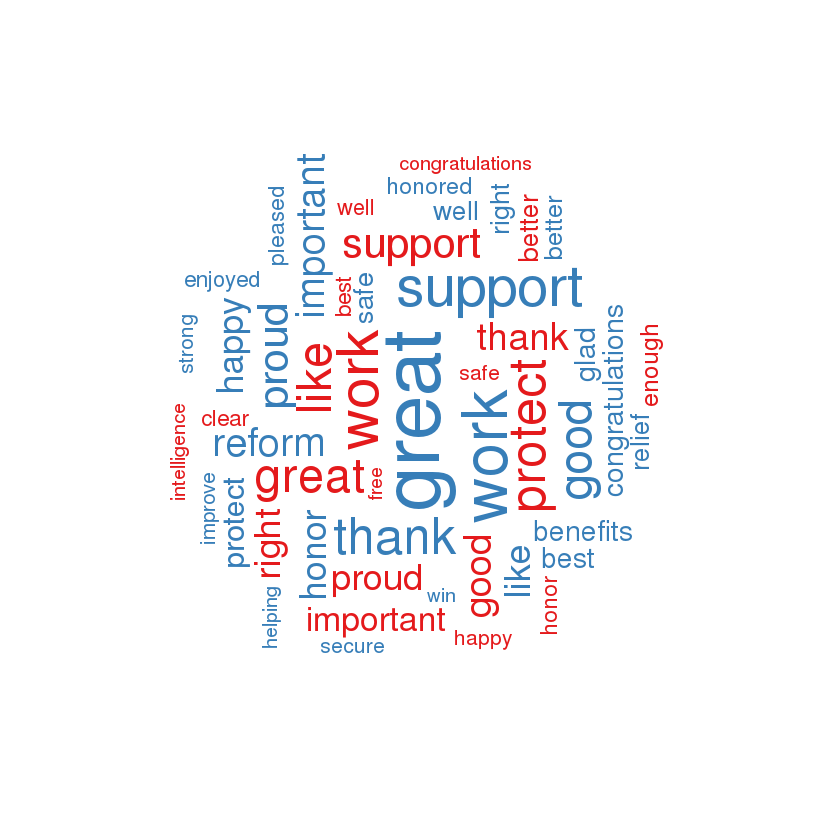

In [31]:
wordcloud(words = sas$word, freq = sas$n, min.freq = 1,
          max.words=50, random.order=FALSE, rot.per=0.5,
           ordered.color=TRUE,
          colors=brewer.pal(3, "Set1")[factor(sas$party)])